# Hate Speech Classification

### Import all necessary libraries

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import keras
import tensorflow as tf

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# Scrub the data from IMDB

### Get all genres

In [7]:
genre_response = requests.get("https://api.themoviedb.org/3/genre/movie/list?api_key=50298e4210ad98f9daba9b5d76b15889&language=en-US")
all_genres = genre_response.json()["genres"]
# for i,v in enumerate(all_genres):
#     v["id"] = i

all_genres

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 80, 'name': 'Crime'},
 {'id': 99, 'name': 'Documentary'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 36, 'name': 'History'},
 {'id': 27, 'name': 'Horror'},
 {'id': 10402, 'name': 'Music'},
 {'id': 9648, 'name': 'Mystery'},
 {'id': 10749, 'name': 'Romance'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 10770, 'name': 'TV Movie'},
 {'id': 53, 'name': 'Thriller'},
 {'id': 10752, 'name': 'War'},
 {'id': 37, 'name': 'Western'}]

### Filter necessary / major genres

In [8]:
#all_genres[all_genres["id"]=="28"]
#type(all_genres)
all_genres = [i for i in all_genres if i['id'] in [28, 99, 27, 878]]
#all_genres.remove(
all_genres

[{'id': 28, 'name': 'Action'},
 {'id': 99, 'name': 'Documentary'},
 {'id': 27, 'name': 'Horror'},
 {'id': 878, 'name': 'Science Fiction'}]

### Function to build url with necessary Genres

In [9]:
def build_url(params, pages=1):
    url = "https://api.themoviedb.org/3/discover/movie?api_key=50298e4210ad98f9daba9b5d76b15889&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&with_watch_monetization_types=flatrate"
    url += f"&with_genres={params}&page={pages}"
    return url

### Function to get all the movies data

In [10]:
def get_movie_data(genre, pages):
    response = requests.get(build_url(genre, pages))
    return response.json()


creating empty dataframe to load the data

In [12]:
movies_data = pd.DataFrame(columns=["movie_name", "plot", "genre"])

### Function to load all the movies data with only necessary features

In [13]:
def load_movies_data(genre, pages):
    data = pd.DataFrame(columns=["movie_name", "plot", "genre"])
    for i in get_movie_data(genre, pages)["results"]:
        # print({"movie_name" : i["original_title"], "plot": i["overview"], "genre": i["genre_ids"]})
        data =  pd.concat([data, pd.DataFrame.from_records([{"movie_name" : i["original_title"], "plot": i["overview"], "genre": i["genre_ids"], "primary_genre": genre}])])
    return data

maximum number of data for each genre

In [14]:
DATA_LIMIT = 2000

# Load all the necessary data

In [15]:
num_of_genres = 0
for i in all_genres:
    num_of_genres+=1
    pages =1
    while(movies_data.shape[0] < (DATA_LIMIT * num_of_genres)):
        movies_data = pd.concat([movies_data, load_movies_data(i['id'], pages)])
        pages += 1

data has 8000 records with 4 dimensions

In [16]:
movies_data.shape

(8000, 4)

## Cleaning the dataset
#### Remove URLs, abbrevations, email, signs 
#### Stop words removal
#### Stemming - Porter Stemmer is used
#### Lemmatixation - Wornet Lemmatizer
#### Removing other non alphabetic character

In [17]:
stop_words = stopwords.words('english')
stop_words.extend(["br"]) # Added the line break tag br to the stop words as it is not necessary
stop_words = set(stop_words)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize(word):
    return lemmatizer.lemmatize(word)

def clean_text(text):
    text = text.lower().split()
    
    stops = stop_words
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    text = re. sub(r'https?://[A-Za-z0-9./]+', 'url', text)
    text = re. sub(r"[^A-Za-z0-g^,!.V'+-=]"," ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re. sub(r"\'ve", "have", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re. sub(r"\'re", "are", text)
    text = re.sub(r"\'d", "would", text)
    text = re.sub(r"\'ll", "will", text)
    text = re.sub(r",", " ",text)
    text = re.sub(r"\.", " ",text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re. sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + " , text)
    text = re.sub(r"\-", " - " , text)
    text = re.sub(r"\=", " = " , text)
    text = re. sub(r"'", " " , text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re. sub(r":", " : ", text)
    text = re. sub(r" e g ", " eg ", text)
    text = re. sub(r" b g ", " bg ", text)
    text = re. sub(r"j k", " jk ", text)
    text = re. sub(r" u s ", " american ", text)
    text = re. sub(r"\0s", "0", text)
    text = re. sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re. sub(r'(\w)\1{2,}', r'\1\1', text)
    text = re.sub(r'\w(\w)\1{2}','', text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1\1", text)
    stemmer.stem(text)
    return lemmatize(text)

def del_NonAlphawords(sentence):
    return " ".join([word for word in sentence.split() if word.isalpha()])

###  Create a lamda function with our method

In [18]:
clean_all = lambda x : del_NonAlphawords(clean_text(x))

### Apply the lamda function to clean the data

In [19]:
movies_data["plot"] = movies_data["plot"].apply(clean_all)

Rename the values of Genre

In [40]:
plot_data = movies_data.copy()
plot_data["primary_genre"] = movies_data.primary_genre.replace({28: "Action", 99: 'Documentary', 27:'Horror', 878: 'Science Fiction'})

## Data Analysis

### Plot the number of data for each class


<AxesSubplot:>

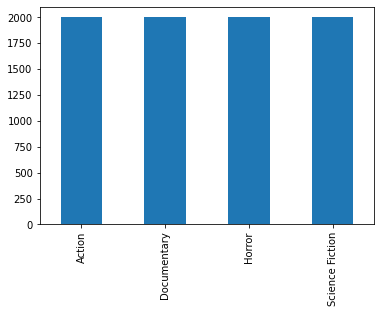

In [41]:
plot_data.primary_genre.value_counts().sort_values().plot(kind = 'bar')

## Word cloud building for all the classes

In [42]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def plot_word_cloud(filter=None):
    if(filter):
        data =plot_data[plot_data["primary_genre"] == filter]["plot"] 
    else:
        data = plot_data["plot"]
    wordcloud = WordCloud().generate(str(data))
    print(f"Word cloud for {filter if filter else 'all' } Genere")
    plt.figure()
    plt.imshow(wordcloud)

    plt.axis("off")

    plt.show()

Word cloud for all Genere


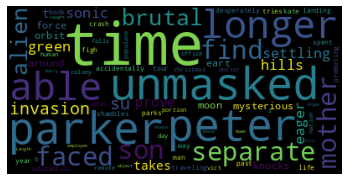

In [43]:
plot_word_cloud()

Word cloud for Action Genere


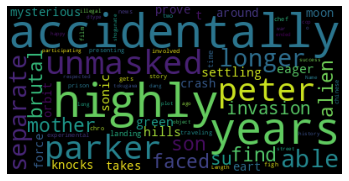

In [44]:
plot_word_cloud("Action")

Word cloud for Documentary Genere


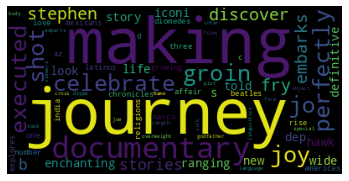

In [45]:
plot_word_cloud("Documentary")

Word cloud for Horror Genere


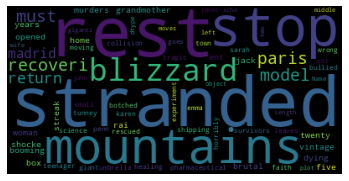

In [46]:
plot_word_cloud("Horror")

Word cloud for Science Fiction Genere


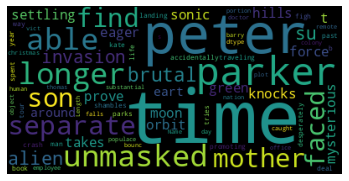

In [47]:
plot_word_cloud("Science Fiction")

## Venn Diagram to show the available number of words on all classes and their common number of words

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [49]:
def get_words(filter=None):
    vectorizer = CountVectorizer()
    if(filter):
        data =plot_data[plot_data["primary_genre"] == filter]["plot"] 
    else:
        data = plot_data["plot"]
    X = vectorizer.fit_transform(data)
    return set(vectorizer.get_feature_names_out())

In [50]:
venn_data = {"Action": get_words("Action"), "Horror": get_words("Horror"), "Documentary": get_words("Documentary"), "Science Fiction": get_words("Science Fiction")}


<AxesSubplot:>

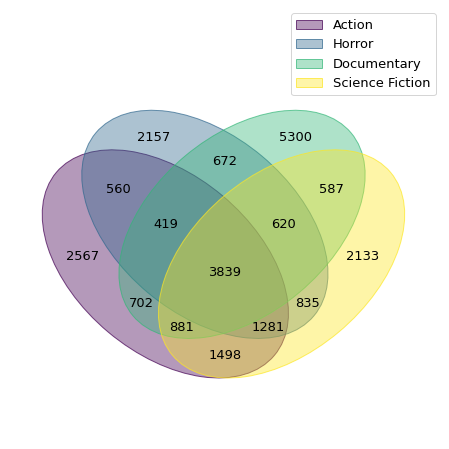

In [51]:
from venn import venn
venn(venn_data)

### Tokenize the sentence into seperate words

In [24]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(movies_data["plot"])
word_index = tokenizer.word_index

### Load Glove Word embedding matrix

In [25]:
path_to_glove_file = os.path.join("glove.42B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [26]:
num_tokens = len(word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 23496 words (581 misses)


# Tuned Hyper Parameters to get good accuracy

In [53]:
MAX_SEQUENCE_LENGTH = 10000
filters=32
kernel_size= 32
lstm_units = 100
lr=0.01
l2_reg=0.00001


## Build the Model

### Embedding Layer with Glove data 100 dimensions and input length of 1000
### SpatialDropout1D Layer to prevent overfitting
### Conv1D considering sentence a matrix and extrating import features with 3s as filter and 32 as kernel size
### LeakyReLU as activation for next layer
### MaxPooling1D to compress the conv1d layer data
### bidirectional LSTM with 100 units


In [54]:
from tensorflow import keras
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(l2_reg), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(l2_reg), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(np.unique(movies_data["primary_genre"]).shape[0],activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Get unique classes

In [29]:
classes = np.unique(movies_data["primary_genre"])
classes

array([ 27.,  28.,  99., 878.])

Split the dataset into 80% train and 20% test data

In [30]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.callbacks import TensorBoard



encoder = LabelEncoder()
encoder.fit(movies_data["primary_genre"])
y_data = encoder.transform(movies_data["primary_genre"])

categorical_labels = to_categorical(y_data,num_classes=len(classes))
X_train, X_test, Y_train, Y_test = train_test_split(movies_data["plot"], categorical_labels, test_size=0.2)

Pad the input to 10000 as uniform length of input size is required for training

In [31]:
pad_X_train = pad_sequences(
   tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH
 )
pad_X_test =  pad_sequences(
     tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH
   )

## Start training the model

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model.fit(pad_X_train, Y_train, epochs=200, callbacks=[tb_callback])


Epoch 1/200
200/200 [==============================] - 2722s 14s/step - loss: 1.0192 - categorical_accuracy: 0.5491
Epoch 2/200
200/200 [==============================] - 2451s 12s/step - loss: 0.8861 - categorical_accuracy: 0.6359
Epoch 3/200
200/200 [==============================] - 2400s 12s/step - loss: 0.8565 - categorical_accuracy: 0.6475
Epoch 4/200
200/200 [==============================] - 2424s 12s/step - loss: 0.8228 - categorical_accuracy: 0.6647
Epoch 5/200
200/200 [==============================] - 2441s 12s/step - loss: 0.8088 - categorical_accuracy: 0.6733
Epoch 6/200
200/200 [==============================] - 2404s 12s/step - loss: 0.7865 - categorical_accuracy: 0.6839
Epoch 7/200
200/200 [==============================] - 2383s 12s/step - loss: 0.7825 - categorical_accuracy: 0.6812
Epoch 8/200
200/200 [==============================] - 2366s 12s/step - loss: 0.7641 - categorical_accuracy: 0.6870
Epoch 9/200
200/200 [==============================] - 2359s 12s/step - 

KeyboardInterrupt: 

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        7223700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 10000, 300)       0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 10000, 32)         307232    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10000, 32)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5000, 32)         0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 5000, 200)        1

# Testing the model

Accuracy of the test dataset

In [34]:
from keras.preprocessing.sequence import pad_sequences
accr = model.evaluate(pad_X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

50/50 [==============================] - 94s 2s/step - loss: 1.3827 - categorical_accuracy: 0.6444
Test set
  Loss: 1.383
  Accuracy: 0.644


Build the confusion matrix

In [36]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(pad_X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
cf = multilabel_confusion_matrix(ytrue, yhat)

# Plot the confusion matrix

In [66]:
def plot_CF(class_lab=0, label=""):
    import seaborn as sns;
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf[class_lab].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf[class_lab].flatten()/np.sum(cf[class_lab])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf[class_lab]/np.sum(cf[class_lab]), annot=labels, fmt='')
    ax.set_title(f'Confusion Matrix for \n {label} Genre')
    plt.xlabel('Predicted')

    plt.ylabel('Actual')

    plt.grid(False)

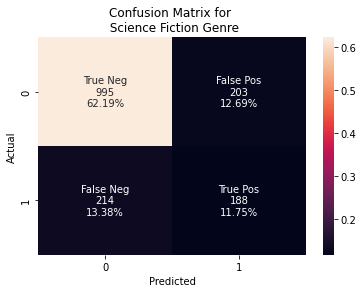

In [67]:
plot_CF(3,"Science Fiction")

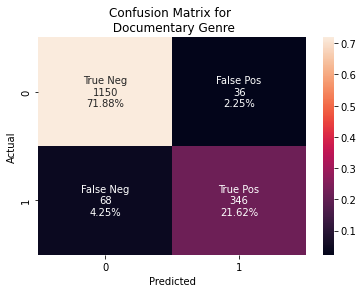

In [68]:
plot_CF(2,"Documentary")

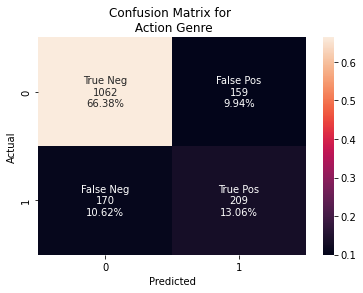

In [69]:
plot_CF(1,"Action")

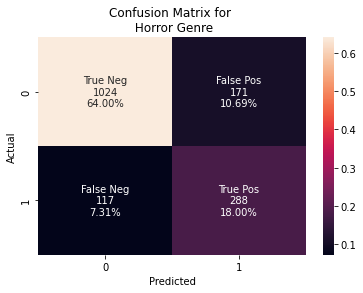

In [70]:
plot_CF(0,"Horror")

# Save the Model to be used in the application

In [37]:
model.save('MovieClassify.h5')

# Pickel the tokenizer for input conversion in the model

In [38]:
import pickle
with open("tokenizer.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)